# Modeling of duration esitmation under memory load

## Model structure

1. Duration Encoding

Given that scalar property is the key feature of duration estimation, the sensory measure (S) is assumed to be a log-scale of physical duration (D):

$$S = \log(D) + \epsilon$$

where $\epsilon$ is the noise term. 

The encoding is influenced by memory load (M) and the encoding function is assumed to be Gausian - $S_{wm} ~ N(\mu_{wm}, \sigma_{wm}^2)$, where $\mu_{wm}$ and $\sigma_{wm}^2$ are the mean and variance of the encoding function.

$$\mu_{wm} = \log{D} - k_s \log(M)$$

changed equation in the previous model from $$\sigma_{wm}^2 = \sigma_s^2 (1+ l_s\cdot \log(M+T_g))$$ to 

$$\sigma_{wm}^2 = \sigma_s^2 (1 +  l_s \cdot \log(M) + t_s \cdot \log(T))$$ by adding new parameter $$t_s$$
\cdot 
where M represents the set size of the working memory task, T is the retention interval (gap) and $[k_s, l_s, t_s]$ are the scaling factors, $\sigma_s^2$ is the variance of the sensory measure.



## 2. Bayesian integration

Given all trials were randomly intermixed, the posterior probability of the duration estimate is given by $N(\mu_{post}, \sigma_{post}^2)$, where $\mu_{post}$ and $\sigma_{post}^2$ are the mean and variance of the posterior distribution. According to the Bayesian integration theory, the posterior distribution is a weighted sum of the sensory measure and the prior distribution:

$$\mu'_{post} = (1-w_p)\mu_{wm} + w_p\mu_{prior}$$

where
$w_p = \frac{1/\sigma_{prior}^2}{1/\sigma_{wm}^2 + 1/\sigma_{prior}^2}$.


## 3. Duration Reproduction

Having to maintain a number (‘load’) of items in working memory during the duration-reproduction phase would influence the monitoring of the elapsed time of the reproduction. Conceiving of the monitoring of the sensory ‘elapsed time’ (i.e., the time from the starting key press onwards), $\mu_{elapsed}$, as involving the counting of ‘clock ticks’ by an accumulator, lapses and diversion of attention to other, non-temporal processes would result in some ticks being lost, or missed, in the count. Here we assume that the loss is proportional to the memory load, that is: $\mu_{elapsed}-k_rM$, where $k_r$ is a scaling factor. The decision to then release the reproduction key is determined by the comparison between the perceived ‘elapsed time’ and the memorized target duration, $μ'_{post}$:

$$|\mu'_{post}-(\mu_{elapsed}-k_rM)|< \delta $$

which is equivalent to comparing the sensory elapsed time to $\mu'_{post}+k_rM$. 		

We transfer logscal to linear scale:

$$\mu_r = e^{\mu'_{post}+k_rM + {\sigma'}_{post}^2/2}$$

$$\sigma_r^2 = |e^{\sigma_{post}^2} -1|e^{2(\mu_{post}+k_rM)+{\sigma'}_{post}^2}$$

where $\mu_r$ and $\sigma_r^2$ are the mean and variance of the reproduction distribution.

The impact of non-temporal noise will be reduced as duration increases, and we assume:

$$\sigma_{observed}^2 = \sigma_r^2 + \sigma_{non-temporal}^2/D$$

where $\sigma_{non-temporal}^2$ is the variance of the non-temporal noise.

## PYMC Model

In [51]:
#!pip install numpy
#!pip install pymc
#!pip install arviz
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install datetime
#!pip install pytensor


import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import datetime as dt
import os
import pytensor.tensor as pt


In [52]:
# print the date of analysis
print('Last updated on:', dt.datetime.now())

Last updated on: 2025-11-15 07:39:44.715919


In [53]:
# get the parent directory
cpath = os.path.dirname(os.getcwd())
# import raw data from csv file cpath + data/AllData.csv
expData = pd.read_csv(cpath + '/data/AllExpData_color_new.csv')

# map the column Exp to ExpName: Exp1 -> Baseline, Exp2 -> Encoding, Exp3 -> Reproduction, Exp4 -> Both, Exp5 -> Both_gap
expData['ExpName'] = expData['Exp'].map({'Exp1': 'Baseline', 
										 'Exp2': 'Encoding', 
										 'Exp3': 'Reproduction', 
										 'Exp4': 'Both', 
										 'Exp5': 'Both_gap'})
expData.head()

freeParam = False
constrain = [0,0,0,0]
modelname = 'FullFreeParameters'
if freeParam:
    modelname = 'FullFreeParameters'
else:
    modelname = 'FullExperimentWise'
    
modelpath = modelname +'/'



In [54]:
# get the parent directory
cpath = os.path.dirname(os.getcwd()) # 项目根路径或你保存数据的根路径
OUTPUT_PATH = os.path.join(cpath, 'data', modelpath)
savefigpath = cpath + '/data/'+ modelpath

In [55]:
expData.ExpName.unique()

array(['Encoding', 'Reproduction', 'Baseline', 'Both', 'Both_gap'],
      dtype=object)

In [56]:
# find out the unique gap from ExpName Both_gap
expData[expData['ExpName'] == 'Both_gap']['gap'].unique()

array([2, 1])

In [57]:
# define PYMC partial pooling model
trace = 0

def hModel(dat, constrain):
    subid = (dat.NSub - 1).astype(int)
    nsub = len(dat.NSub.unique())

    # log-transformed predictors
    wm_idx = np.log(dat.WMSize.to_numpy())
    gap_idx = np.log(dat.Gap.to_numpy())
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    lnDur = np.log(durs)

    niter = 2000

    with pm.Model() as WMmodel:
        # -----------------------------
        # Hierarchical Priors
        # -----------------------------
        # var_s: sensory noise
        mu_var_s = pm.HalfCauchy('mu_var_s', beta=1)
        sd_var_s = pm.HalfCauchy('sd_var_s', beta=1)
        var_s_raw = pm.Normal('var_s_raw', 0, 1, shape=nsub)
        var_s = pm.Deterministic('var_s', pm.math.abs(mu_var_s + sd_var_s * var_s_raw))

        # mu_p: prior mean (log-space)
        mu_mu_p = pm.Normal('mu_mu_p', mu=0, sigma=1)
        sd_mu_p = pm.HalfCauchy('sd_mu_p', beta=1)
        mu_p_raw = pm.Normal('mu_p_raw', 0, 1, shape=nsub)
        mu_p = pm.Deterministic('mu_p', pm.math.clip(mu_mu_p + sd_mu_p * mu_p_raw, -1, 1.3))

        # var_p: prior variance (log-space)
        mu_var_p = pm.HalfNormal('mu_var_p', sigma=1)
        sd_var_p = pm.HalfNormal('sd_var_p', sigma=1)
        var_p_raw = pm.Normal('var_p_raw', 0, 1, shape=nsub)
        var_p = pm.Deterministic('var_p', pm.math.clip(mu_var_p + sd_var_p * var_p_raw, 0, 1))

        # var_n: motor noise
        mu_var_n = pm.HalfCauchy('mu_var_n', beta=1)
        sd_var_n = pm.HalfCauchy('sd_var_n', beta=1)
        var_n_raw = pm.Normal('var_n_raw', 0, 1, shape=nsub)
        var_n = pm.Deterministic('var_n', pm.math.abs(mu_var_n + sd_var_n * var_n_raw))

        # -----------------------------
        # Other parameters (kept subject-specific)
        # -----------------------------
        k_s = pm.Normal('k_s', mu=0, sigma=0.1, shape=nsub) if constrain[0] else pm.Deterministic('k_s', pt.zeros(nsub))
        l_s = pm.Normal('l_s', mu=0, sigma=0.1, shape=nsub) if constrain[1] else pm.Deterministic('l_s', pt.zeros(nsub))
        k_r = pm.Normal('k_r', mu=0, sigma=0.1, shape=nsub) if constrain[2] else pm.Deterministic('k_r', pt.zeros(nsub))
        t_s = pm.Normal('t_s', mu=0, sigma=0.1, shape=nsub) if constrain[3] else pm.Deterministic('t_s', pt.zeros(nsub))
        
        # -----------------------------
        # Model equations
        # -----------------------------
        D_s = lnDur - k_s[subid] * wm_idx
        var_wm = var_s[subid] * (1 + l_s[subid] * wm_idx + t_s[subid] * gap_idx)
        w_p = var_wm / (var_p[subid] + var_wm)
        u_x = (1 - w_p) * D_s + w_p * mu_p[subid]
        var_x = var_wm * var_p[subid] / (var_wm + var_p[subid])
        u_x1 = u_x + k_r[subid] * wm_idx
        u_r = pm.math.exp(u_x1 + var_x / 2)
        sig_r = pm.math.sqrt((pm.math.exp(var_x) - 1) * pm.math.exp(2 * u_x1 + var_x) + var_n[subid] / durs)

        # -----------------------------
        # Likelihood
        # -----------------------------
        resp_like = pm.Normal('resp_like', mu=u_r, sigma=sig_r, observed=repDur)

        # -----------------------------
        # Sampling
        # -----------------------------
        idata = pm.sample(draws=niter, tune=1000, target_accept=0.9, return_inferencedata=True)

        # Add log_likelihood if missing
        try:
            log_like = pm.compute_log_likelihood(idata, model=WMmodel)
            if "log_likelihood" not in idata.groups():
                idata.add_groups({"log_likelihood": log_like})
        except Exception as e:
            print(f"Could not recompute log_likelihood: {e}")

    return idata, WMmodel


In [58]:

# define a function to calculate the mean and sd of posterior samples for each subject
def getPosteriorSummary(posterior_samples, dat):
	# create a dataframe for mean posterior samples with following columns: NSub, curDur, WMSize, mPred, sdPred
	posterior_df = pd.DataFrame(columns = ['NSub', 'curDur', 'WMSize', 'mPred', 'sdPred'])
	# from dat get unique NSub, curDur, WMSize, and loop through them and select rows from dat
	nsub = len(dat.NSub.unique())
	nDur = len(dat.curDur.unique())
	nWM = len(dat.WMSize.unique())
	for i in range(nsub):  #i = 0,1,..., 15
		for j in range(nDur):
			for k in range(nWM):
				subid = i + 1 # subid = 1,2,..., 16
				curDur = dat.curDur.unique()[j]
				WMSize = dat.WMSize.unique()[k]
				idx = (dat.NSub == subid) & (dat.curDur == curDur) & (dat.WMSize == WMSize)
				if np.sum(idx) > 0:
					#log scale to linear scale
					mPred = np.mean(posterior_samples[:, idx])
					sdPred = np.std(posterior_samples[:, idx])
					df = pd.DataFrame({'NSub': subid, 'curDur': curDur, 'WMSize': WMSize, 'mPred': mPred, 'sdPred': sdPred}, index = [0])
					# concatenate the dataframe
					posterior_df = pd.concat([posterior_df, df], ignore_index = True)
	# calculate the observed means and standard deviations
	mdat = dat.groupby(['NSub', 'curDur', 'WMSize']).agg(
		repDur_mean=('repDur', 'mean'),
		repDur_std=('repDur', 'std')
	).reset_index()

	# Perform the merge with the posterior dataframe on the common keys
	mdat = pd.merge(mdat, posterior_df, on=['NSub', 'curDur', 'WMSize'])

	# Calculate repErr, predErr, repCV, and predCV
	mdat['repErr'] = mdat['repDur_mean'] - mdat['curDur']
	mdat['predErr'] = mdat['mPred'] - mdat['curDur']
	mdat['repCV'] = mdat['repDur_std'] / mdat['repDur_mean']
	mdat['predCV'] = mdat['sdPred'] / mdat['mPred']
	return mdat

# Define a customized color palette for the plot
customized_palette = sns.color_palette(['#d9d9d9', '#838383', '#3b3b3b'])

# define a function to plot oberved and predicted data (bias, CV, and scatter plot)
def plotModelPred(mdat, figname='model_pred.png'):
	# Ensure WMSize is treated as a categorical variable
	mdat['WMSize'] = mdat['WMSize'].astype('category')
	# Create a figure and axes with three subplots
	fig, ax = plt.subplots(1, 3, figsize=(9, 3))
	# Set a white background with a more scientific style
	sns.set_theme(style="white", context="paper")

	# Plot the bias (fig_bias) on the left axis (ax[0])
	sns.pointplot(
		data=mdat, x='curDur', y='repErr', hue='WMSize', palette=customized_palette,
		ax=ax[0],  linestyles='', errorbar = 'se', dodge=0.2, legend=False
	)
	sns.pointplot(
		data=mdat, x='curDur', y='predErr', hue='WMSize', palette=customized_palette,
		ax=ax[0], markers='', linestyles='-', errorbar=None
	)
	# add label figname to the bottom left corner of the first axis
	ax[0].text(0.05, 0.05, figname.capitalize(), transform=ax[0].transAxes, fontsize=10, color='black')
	ax[0].set_title('Bias')
	ax[0].set_xlabel('Duration (s)')
	ax[0].set_ylabel('Rep. Bias (s)')
	ax[0].legend(title='Memory Load')
	# Plot the CV (fig_cv) on the right axis (ax[1])
	sns.pointplot(
		data=mdat, x='curDur', y='repCV', hue='WMSize', palette=customized_palette,
		ax=ax[1],  linestyles='', errorbar = 'se', dodge = 0.2, legend=False
	)
	sns.pointplot(
			data=mdat, x='curDur', y='predCV', hue='WMSize', palette=customized_palette,
			ax=ax[1], markers='', linestyles='-', errorbar = None, legend = False
		)
	ax[1].set_title('CV')
	ax[1].set_xlabel('Duration (s)')
	ax[1].set_ylabel('Mean CV')
	# Plot the scatter plot (fig_scatter) on the right axis (ax[2])
	sns.scatterplot(
		data = mdat, x = 'repErr', y = 'predErr', hue = 'WMSize', palette=customized_palette,
		ax = ax[2], legend = False)
	ax[2].set_title('Observed vs. Predicted Bias')
	ax[2].set_xlabel('Observed Bias (s)')
	ax[2].set_ylabel('Predicted Bias (s)')
	# Adjust the layout
	plt.tight_layout()
	# save the figure
	plt.savefig(savefigpath + figname + '_model_pred.png', dpi=600)
	# Show the plot
	plt.show()


In [59]:
def runModel(dat, constrain, model_name):
    trace, model = hModel(dat, constrain)

    with model:
        ppc = pm.sample_posterior_predictive(trace, var_names=['resp_like'])
        posterior_resp = ppc.posterior_predictive['resp_like'].to_numpy()
        posterior_samples = posterior_resp.reshape(-1, posterior_resp.shape[2])

    mdat = getPosteriorSummary(posterior_samples, dat)
    para = az.summary(trace)

    # Save outputs
    az.to_netcdf(trace, cpath + '/data/' + model_name + '_trace.nc')
    mdat.to_csv(cpath + '/data/' + model_name + '_mdat.csv')
    para.to_csv(cpath + '/data/' + model_name + '_para.csv')

    # === LOO diagnostics ===
    try:
        loo = az.loo(trace, model=model)
        az.plot_khat(loo)
        plt.tight_layout()
        plt.savefig(savefigpath + model_name + '_khat.png', dpi=300)
        plt.show()
        print(az.summary(loo, var_names=["pareto_k"]))
    except Exception as e:
        print(f"LOO computation failed: {e}")

    return trace, model, para, mdat

In [60]:
modelpath

'FullExperimentWise/'

## Experiments with Memory Load on Encoding


Using hierarchical Bayesian modeling, we can estimate the parameters of the model. The model is implemented in PYMC. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw, k_s, l_s]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1152 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


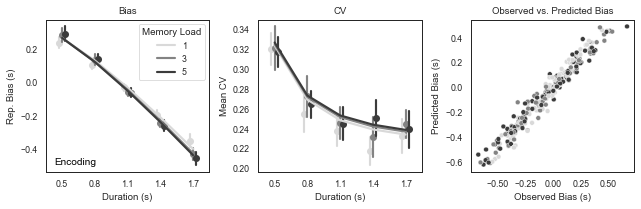

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.012,0.047,-0.072,0.105,0.001,0.001,5831.0,2540.0,1.0
k_s[1],0.017,0.033,-0.042,0.080,0.000,0.000,5336.0,2844.0,1.0
k_s[2],0.088,0.054,-0.012,0.192,0.001,0.001,6107.0,2535.0,1.0
k_s[3],0.025,0.048,-0.064,0.118,0.001,0.001,6948.0,2536.0,1.0
k_s[4],-0.125,0.066,-0.251,-0.003,0.001,0.001,6203.0,2775.0,1.0
...,...,...,...,...,...,...,...,...,...
var_n[11],0.047,0.013,0.024,0.073,0.000,0.000,2857.0,2692.0,1.0
var_n[12],0.016,0.006,0.005,0.028,0.000,0.000,2686.0,3243.0,1.0
var_n[13],0.003,0.002,0.000,0.007,0.000,0.000,2781.0,2724.0,1.0
var_n[14],0.007,0.002,0.003,0.011,0.000,0.000,3753.0,3368.0,1.0


In [61]:
dat_encoding = expData[expData['ExpName'] == 'Encoding']
firstrun = True
if firstrun:
    if freeParam:
        constrain = [1,1,1,0] # unconstrained, use all scaling parameters, ks, ls, ts, wm_sig, and kr
    else:
        constrain = [1,1,0,0]  # constrained, use only  ks, ls
    encoding_trace, encoding_model, encoding_para, encoding_mdat = runModel(dat_encoding, constrain, modelpath+'encoding')
else:
    encoding_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'encoding_trace.nc')
    encoding_mdat = pd.read_csv(cpath + '/data/'+ modelpath + 'encoding_mdat.csv')
    encoding_para = pd.read_csv(cpath + '/data/'+ modelpath + 'encoding_para.csv')

plotModelPred(encoding_mdat, 'encoding')
az.summary(encoding_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [62]:
# calculate the correlation between mPred vs. repDur_mean using encoding_mdat
np.corrcoef(encoding_mdat['mPred'], encoding_mdat['repDur_mean'])

array([[1.        , 0.96596298],
       [0.96596298, 1.        ]])

In [63]:
np.corrcoef(encoding_mdat['repCV'], encoding_mdat['predCV'])

array([[1.        , 0.82662721],
       [0.82662721, 1.        ]])

## Memory Load on Reproduction


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw, k_r]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1197 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


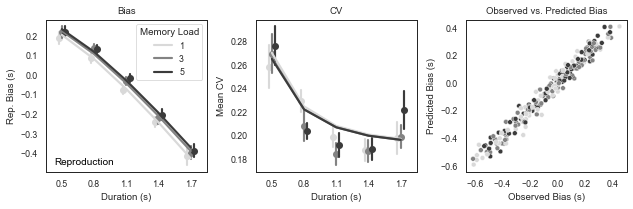

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.003,0.002,0.000,0.006,0.0,0.0,1891.0,2405.0,1.01
var_n[12],0.002,0.002,0.000,0.005,0.0,0.0,3118.0,3008.0,1.00
var_n[13],0.003,0.002,0.000,0.007,0.0,0.0,3693.0,2925.0,1.00
var_n[14],0.005,0.002,0.002,0.008,0.0,0.0,2625.0,3319.0,1.00


In [64]:
dat_reproduction = expData[expData['ExpName'] == 'Reproduction']
firstrun = True
if firstrun:
    if freeParam:
        constrain = [1,1,1,0] # unconstrained, use all scaling factors ks, kr, ls, ts
    else:
        constrain = [0,0,1,0] # constrained, only use scaling factors ks, ts
    reproduction_trace, reproduction_model, reproduction_para, reproduction_mdat = runModel(dat_reproduction, constrain, modelpath+'reproduction')
    reproduction_para
else:
	reproduction_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'reproduction_trace.nc')
	reproduction_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'reproduction_mdat.csv')
	reproduction_para = pd.read_csv(cpath + '/data/' + modelpath + 'reproduction_para.csv')
# plot the model prediction
plotModelPred(reproduction_mdat, 'reproduction')
az.summary(reproduction_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [65]:
np.corrcoef(reproduction_mdat['mPred'], reproduction_mdat['repDur_mean'])

array([[1.        , 0.98303038],
       [0.98303038, 1.        ]])

In [66]:
#correlation of CV
np.corrcoef(reproduction_mdat['repCV'], reproduction_mdat['predCV'])

array([[1.        , 0.69388692],
       [0.69388692, 1.        ]])

In [67]:
reproduction_mdat

,NSub,curDur,WMSize,repDur_mean,repDur_std,mPred,sdPred,repErr,predErr,repCV,predCV
0,1,0.5,1,0.771986,0.281484,0.757123,0.247277,0.271986,0.257123,0.364622,0.326601
1,1,0.5,3,0.717311,0.298764,0.755196,0.245991,0.217311,0.255196,0.416505,0.325731
2,1,0.5,5,0.777309,0.262939,0.755040,0.247272,0.277309,0.255040,0.338268,0.327495
3,1,0.8,1,0.933316,0.218705,0.903567,0.229367,0.133316,0.103567,0.234331,0.253846
4,1,0.8,3,0.914644,0.225974,0.901881,0.227435,0.114644,0.101881,0.247063,0.252179
...,...,...,...,...,...,...,...,...,...,...,...
235,16,1.4,3,1.096584,0.303610,1.088957,0.217041,-0.303416,-0.311043,0.276869,0.199311
236,16,1.4,5,1.168591,0.211863,1.112687,0.221868,-0.231409,-0.287313,0.181298,0.199398
237,16,1.7,1,1.155933,0.133814,1.155446,0.227925,-0.544067,-0.544554,0.115763,0.197261
238,16,1.7,3,1.143946,0.160930,1.211740,0.236649,-0.556054,-0.488260,0.140679,0.195297


## Baseline Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3249 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


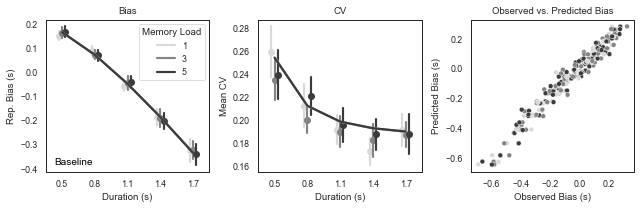

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[1],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[2],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[3],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
k_s[4],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
var_n[11],0.007,0.002,0.004,0.010,0.0,0.0,5161.0,3882.0,1.00
var_n[12],0.003,0.001,0.000,0.006,0.0,0.0,3941.0,3532.0,1.00
var_n[13],0.006,0.002,0.002,0.009,0.0,0.0,219.0,3234.0,1.01
var_n[14],0.011,0.003,0.005,0.017,0.0,0.0,3648.0,2402.0,1.00


In [68]:
dat_baseline = expData[expData['ExpName'] == 'Baseline']
firstrun = True
if firstrun:
    if freeParam:
        constrain = [1,1,1,0] # unconstrained, use all scaling factors
    else:
        constrain = [0,0,0,0] # constrained, only use scaling factors ts
    baseline_trace, baseline_model, baseline_para, baseline_mdat = runModel(dat_baseline, constrain, modelpath + 'baseline')
    baseline_para
else:
	baseline_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'baseline_trace.nc')
	baseline_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'baseline_mdat.csv')
	baseline_para = pd.read_csv(cpath + '/data/' + modelpath + 'baseline_para.csv')
plotModelPred(baseline_mdat, 'baseline')
az.summary(baseline_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [69]:
np.corrcoef(baseline_mdat['mPred'], baseline_mdat['repDur_mean'])

array([[1.        , 0.98832741],
       [0.98832741, 1.        ]])

In [70]:
#correlation of CV
np.corrcoef(baseline_mdat['repCV'], baseline_mdat['predCV'])

array([[1.        , 0.75507781],
       [0.75507781, 1.        ]])

## Memory Load on Encoding and Reproduction


In [71]:
dat_both = expData[expData['ExpName'] == 'Both']
firstrun = True
if firstrun:
	constrain = [1,1,1,0] # scaling factor for k_s, l_s, gap, k_r
	both_trace, both_model, both_para, both_mdat = runModel(dat_both, constrain, modelpath + 'both')
	both_para
else:
	both_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'both_trace.nc')
	both_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'both_mdat.csv')
	both_para = pd.read_csv(cpath + '/data/' + modelpath + 'both_para.csv')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw, k_s, l_s, k_r]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3082 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


LOO computation failed: loo() got an unexpected keyword argument 'model'


In [72]:
both_mdat

,NSub,curDur,WMSize,repDur_mean,repDur_std,mPred,sdPred,repErr,predErr,repCV,predCV
0,1,0.5,1,0.596644,0.186106,0.627924,0.205480,0.096644,0.127924,0.311921,0.327237
1,1,0.5,3,0.525980,0.230800,0.608623,0.202948,0.025980,0.108623,0.438801,0.333455
2,1,0.5,5,0.599990,0.202133,0.599131,0.202576,0.099990,0.099131,0.336894,0.338117
3,1,0.8,1,0.865316,0.246402,0.831845,0.207216,0.065316,0.031845,0.284754,0.249105
4,1,0.8,3,0.809310,0.185616,0.808592,0.203026,0.009310,0.008592,0.229351,0.251086
...,...,...,...,...,...,...,...,...,...,...,...
235,16,1.4,3,1.146593,0.159124,1.123188,0.228377,-0.253407,-0.276812,0.138780,0.203329
236,16,1.4,5,1.145267,0.238150,1.079698,0.220049,-0.254733,-0.320302,0.207942,0.203806
237,16,1.7,1,1.406379,0.345038,1.425542,0.290077,-0.293621,-0.274458,0.245338,0.203485
238,16,1.7,3,1.257090,0.294595,1.307605,0.263511,-0.442910,-0.392395,0.234347,0.201522


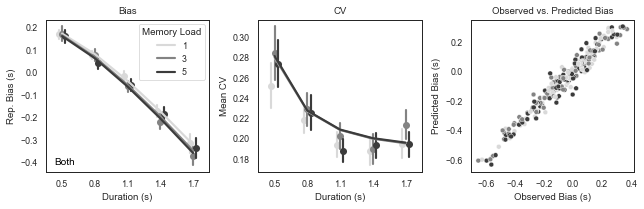

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],0.008,0.086,-0.145,0.179,0.001,0.001,3698.0,2737.0,1.0
k_s[1],0.005,0.088,-0.166,0.163,0.002,0.001,2406.0,2791.0,1.0
k_s[2],-0.005,0.096,-0.184,0.175,0.002,0.001,3756.0,2801.0,1.0
k_s[3],0.002,0.095,-0.165,0.187,0.002,0.001,2972.0,2608.0,1.0
k_s[4],0.005,0.091,-0.159,0.188,0.001,0.001,3935.0,2932.0,1.0
...,...,...,...,...,...,...,...,...,...
var_n[11],0.011,0.005,0.002,0.021,0.000,0.000,4893.0,3499.0,1.0
var_n[12],0.001,0.001,0.000,0.003,0.000,0.000,3433.0,3611.0,1.0
var_n[13],0.003,0.002,0.000,0.007,0.000,0.000,4506.0,3181.0,1.0
var_n[14],0.013,0.004,0.006,0.021,0.000,0.000,5680.0,3471.0,1.0


In [73]:
plotModelPred(both_mdat, 'both')
az.summary(both_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])

In [74]:
np.corrcoef(both_mdat['mPred'], both_mdat['repDur_mean'])

array([[1.        , 0.98681901],
       [0.98681901, 1.        ]])

In [75]:
#correlation of CV
np.corrcoef(both_mdat['repCV'], both_mdat['predCV'])

array([[1.        , 0.77519657],
       [0.77519657, 1.        ]])

Plot for four experiments together

In [ ]:

# Define a function to add the diagonal line
def add_diagonal(*args, **kwargs):
    ax = plt.gca()  # Get the current axis
    limits = [min(-0.6, -0.6), max(0.6, 0.6)]
    ax.plot(limits, limits, color='black', linestyle='--', linewidth=1)  # Draws the diagonal line

# now create the second pred. vs. obs. plot
# Create the FacetGrid, faceting on the ExpName column
g2 = sns.FacetGrid(mdat, col="Exp.", hue="WMSize", height=2.5, aspect=1,col_order=exp_order, palette=c_palette)
# Map the scatter plot for reproduction error (repErr_mean)
g2.map(sns.scatterplot, 'repErr', 'predErr')
# Add the diagonal line to each subplot
g2.map(add_diagonal)

# set x and y labels
g2.set_axis_labels('Observed Error (s)', 'Predicted Error (s)')
#g2.add_legend()
#g2._legend.set_title('Memory Load')
# add label a to the top left corner of the first axis
g2.axes[0,0].text(0.0, 0.98, 'b', transform=g2.fig.transFigure, fontsize=16, fontweight='bold', va='top')
# save the figure to predict_vs_obs.png
plt.savefig(savefigpath + 'predict_vs_obs.png')


In [ ]:
modelpath

## Memory load with Gap on Encoding and Reproduction


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_var_s, sd_var_s, var_s_raw, mu_mu_p, sd_mu_p, mu_p_raw, mu_var_p, sd_var_p, var_p_raw, mu_var_n, sd_var_n, var_n_raw, k_s, l_s, k_r, t_s]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13492 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [resp_like]


LOO computation failed: loo() got an unexpected keyword argument 'model'


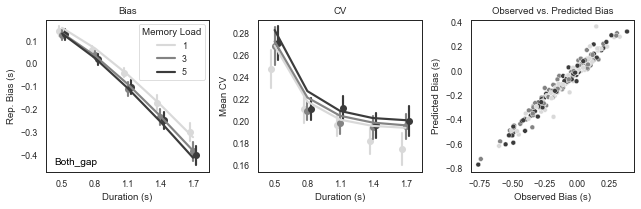

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s[0],-0.028,0.066,-0.144,0.101,0.002,0.001,979.0,1961.0,1.00
k_s[1],-0.006,0.073,-0.136,0.132,0.004,0.003,331.0,1797.0,1.01
k_s[2],0.070,0.075,-0.076,0.203,0.003,0.002,537.0,996.0,1.01
k_s[3],0.057,0.078,-0.086,0.206,0.003,0.002,966.0,1771.0,1.02
k_s[4],-0.048,0.073,-0.184,0.088,0.002,0.002,1176.0,1711.0,1.02
...,...,...,...,...,...,...,...,...,...
var_n[11],0.013,0.003,0.008,0.018,0.000,0.000,483.0,2316.0,1.01
var_n[12],0.021,0.003,0.015,0.025,0.000,0.000,602.0,2093.0,1.00
var_n[13],0.007,0.002,0.003,0.011,0.000,0.000,638.0,1974.0,1.01
var_n[14],0.003,0.001,0.002,0.005,0.000,0.000,823.0,2212.0,1.00


In [76]:
dat_gap = expData[expData['ExpName'] == 'Both_gap']
firstrun = True
if firstrun:
	constrain = [1,1,1,1] # scaling factor for k_s, l_s, gap, k_r
	both_gap_trace, both_gap_model, both_gap_para, both_gap_mdat = runModel(dat_gap, constrain, modelpath + 'both_gap')
else:
	both_gap_trace = az.from_netcdf(cpath + '/data/' + modelpath + 'both_gap_trace.nc')
	both_gap_mdat = pd.read_csv(cpath + '/data/' + modelpath + 'both_gap_mdat.csv')
	both_gap_para = pd.read_csv(cpath + '/data/' + modelpath + 'both_gap_para.csv')
plotModelPred(both_gap_mdat, 'both_gap')
az.summary(both_gap_trace, var_names=['k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'])	


In [ ]:
np.corrcoef(both_gap_mdat['mPred'], both_gap_mdat['repDur_mean'])

In [ ]:
#correlation of CV
np.corrcoef(both_gap_mdat['repCV'], both_gap_mdat['predCV'])

Note: Visual differences, $l_s$ was higher for Exp. 6a than others, while $k_r$ was close to zero for Exp. 6a. 

In [259]:
def compute_subject_level_k_statistics(trace, k_param):
    """
    Computes the mean and standard deviation of parameter k_param for each subject
    from a PyMC InferenceData object (trace).

    Parameters:
    ----------
    trace : arviz.InferenceData
        The trace from the PyMC model containing posterior samples.
    k_param : str
        The name of the parameter (e.g., 'k_s', 'l_s', 't_s', 'k_r').

    Returns:
    -------
    k_mean : np.ndarray
        The posterior mean of the parameter for each subject.
    k_sd : np.ndarray
        The posterior standard deviation of the parameter for each subject.
    """

    # Check if parameter exists in the trace
    if k_param not in trace.posterior:
        raise ValueError(f"Parameter '{k_param}' not found in trace.posterior.")

    # Extract posterior samples for k_param: shape (nchains, ndraws, nsub)
    k_samples = trace.posterior[k_param].values

    # Flatten chains and draws -> shape (nchains * ndraws, nsub)
    k_samples_flat = k_samples.reshape(-1, k_samples.shape[-1])

    # Compute mean and standard deviation across posterior samples
    k_mean = np.mean(k_samples_flat, axis=0)
    k_sd = np.std(k_samples_flat, axis=0)

    return k_mean, k_sd

In [260]:
modelpath

'NoiseInBothPhasesWithConstrainedParameters/'

In [261]:
#'k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n'

ks_encoding, ks_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_s')
ls_encoding, ls_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'l_s')
kr_encoding, kr_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_r')
ts_encoding, ts_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 't_s')
var_s_encoding, var_s_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_s')
mu_p_encoding, mu_p_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'mu_p')
var_p_encoding, var_p_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_p')
var_n_encoding, var_n_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'var_n')


ks_reproduction, ks_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_s')
ls_reproduction, ls_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'l_s')
kr_reproduction, kr_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_r')
ts_reproduction, ts_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 't_s')
var_s_reproduction, var_s_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_s')
mu_p_reproduction, mu_p_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'mu_p')
var_p_reproduction, var_p_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_p')
var_n_reproduction, var_n_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'var_n')

ks_both, ks_both_sd = compute_subject_level_k_statistics(both_trace, 'k_s')
ls_both, ls_both_sd = compute_subject_level_k_statistics(both_trace, 'l_s')
kr_both, kr_both_sd = compute_subject_level_k_statistics(both_trace, 'k_r')
ts_both, ts_both_sd = compute_subject_level_k_statistics(both_trace, 't_s')
var_s_both, var_s_both_sd = compute_subject_level_k_statistics(both_trace, 'var_s')
mu_p_both, mu_p_both_sd = compute_subject_level_k_statistics(both_trace, 'mu_p')
var_p_both, var_p_both_sd = compute_subject_level_k_statistics(both_trace, 'var_p')
var_n_both, var_n_both_sd = compute_subject_level_k_statistics(both_trace, 'var_n')

ks_both_gap, ks_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_s')
ls_both_gap, ls_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'l_s')
kr_both_gap, kr_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_r')
ts_both_gap, ts_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 't_s')
var_s_both_gap, var_s_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_s')
mu_p_both_gap, mu_p_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'mu_p')
var_p_both_gap, var_p_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_p')
var_n_both_gap, var_n_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'var_n')


ks_baseline, ks_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_s')
ls_baseline, ls_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'l_s')
kr_baseline, kr_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_r')
ts_baseline, ts_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 't_s')
var_s_baseline, var_s_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_s')
mu_p_baseline, mu_p_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'mu_p')
var_p_baseline, var_p_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_p')
var_n_baseline, var_n_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'var_n')


In [264]:
# combine means together
para = [ks_encoding, ks_reproduction, ks_baseline, ks_both, ks_both_gap,
		ls_encoding, ls_reproduction, ls_baseline, ls_both, ls_both_gap,
		kr_encoding, kr_reproduction, kr_baseline, kr_both, kr_both_gap, 
        ts_encoding, ts_reproduction, ts_baseline, ts_both, ts_both_gap, 
		var_s_encoding, var_s_reproduction, var_s_baseline, var_s_both, var_s_both_gap, 
		mu_p_encoding, mu_p_reproduction, mu_p_baseline, mu_p_both, mu_p_both_gap, 
        var_p_encoding, var_p_reproduction, var_p_baseline, var_p_both, var_p_both_gap, 
		var_n_encoding, var_n_reproduction,  var_n_baseline, var_n_both, var_n_both_gap]
# reshape the array, each array has (16,)
para_r = np.stack(para, axis=0).reshape(-1, 80).T
# create a dataframe
df_para = pd.DataFrame(para_r, columns = ['ks','ls','kr', 'ts', 'var_s', 'mu_log', 'sigma_log', 'var_n'])

df_para['mu_p'] = np.exp(df_para['mu_log'] + 0.5 * df_para['sigma_log']**2)
df_para['var_p'] = np.sqrt((np.exp(df_para['sigma_log']**2) - 1) * np.exp(2*df_para['mu_log'] + df_para['sigma_log']**2))
df_para['Experiment'] = ['Encoding']*16 + ['Reproduction']*16 + ['Baseline']*16 + ['Both']*16 + ['Both_gap']*16
# delete mean prior and variance of prior in log scale
df_para = df_para.drop(columns=['mu_log', 'sigma_log'])
df_para.to_csv(OUTPUT_PATH + '/'+ modelname + '_ParaList.csv')
df_para.head()



,ks,ls,kr,ts,var_s,var_n,mu_p,var_p,Experiment
0,0.040401,0.048078,0.0,0.0,0.113457,0.030830,0.999688,0.076749,Encoding
1,0.030257,0.048385,0.0,0.0,0.066795,0.010156,0.799924,0.067574,Encoding
2,0.063477,0.054511,0.0,0.0,0.127223,0.009272,0.941893,0.042496,Encoding
3,0.045627,0.056723,0.0,0.0,0.098857,0.016717,1.108657,0.053517,Encoding
4,0.027527,0.062315,0.0,0.0,0.382973,0.013172,1.134885,0.199607,Encoding


In [265]:
df_para

,ks,ls,kr,ts,var_s,var_n,mu_p,var_p,Experiment
0,0.040401,0.048078,0.000000,0.000000,0.113457,0.030830,0.999688,0.076749,Encoding
1,0.030257,0.048385,0.000000,0.000000,0.066795,0.010156,0.799924,0.067574,Encoding
2,0.063477,0.054511,0.000000,0.000000,0.127223,0.009272,0.941893,0.042496,Encoding
3,0.045627,0.056723,0.000000,0.000000,0.098857,0.016717,1.108657,0.053517,Encoding
4,0.027527,0.062315,0.000000,0.000000,0.382973,0.013172,1.134885,0.199607,Encoding
...,...,...,...,...,...,...,...,...,...
75,0.050218,0.079061,0.020569,0.050867,0.115644,0.014302,0.962574,0.055714,Both_gap
76,0.053318,0.044359,0.037697,0.085802,0.060791,0.022776,1.113039,0.062615,Both_gap
77,0.093988,0.073841,0.002117,0.074911,0.157864,0.007705,0.726708,0.073872,Both_gap
78,0.033048,0.058422,0.044999,0.093921,0.049562,0.003272,0.879954,0.037017,Both_gap


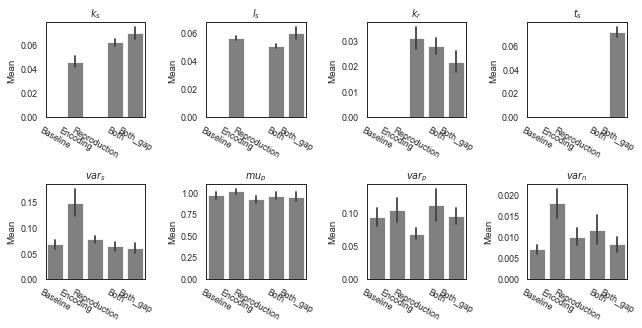

In [271]:
#plot mean and SEs of 'k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n' as a function of Experiment
fig, ax = plt.subplots(2, 4, figsize=(9, 5))
fig.suptitle("", fontsize=14)

params = [
    ('ks', '$k_s$'),
    ('ls', '$l_s$'),
    ('kr', '$k_r$'),
    ('ts', '$t_s$'),
    ('var_s', '$var_s$'),
    ('mu_p', '$mu_p$'),
    ('var_p', '$var_p$'),
    ('var_n', '$var_n$')
]

# 循环绘制子图
for i, (param, title) in enumerate(params):
    row, col = divmod(i, 4)
    sns.barplot(
        data=df_para,
        x='Experiment',
        y=param,
        errorbar='se',
        ax=ax[row, col],
        color='gray'
    )
    ax[row, col].set_title(title)
    ax[row, col].set_ylabel('Mean')
    ax[row, col].set_xlabel('')
    ax[row, col].tick_params(axis='x', rotation=-30)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(savefigpath + 'Para_' + modelname + '.png', dpi=1200)
plt.show()


In [1]:
#plot mean and SEs of 'k_s','l_s','k_r', 't_s', 'var_s', 'mu_p', 'var_p', 'var_n' as a function of Experiment
fig, ax = plt.subplots(2, 4, figsize=(9, 5))
fig.suptitle("", fontsize=14)

# 定义颜色列表
colors = ["#999999", "#E69F00", "#56B4E9", "#1a9641", "#d7191c"]
params = [
    ('ks', '$k_s$'),
    ('ls', '$l_s$'),
    ('kr', '$k_r$'),
    ('ts', '$t_s$'),
    ('var_s', '$var_s$'),
    ('mu_p', '$mu_p$'),
    ('var_p', '$var_p$'),
    ('var_n', '$var_n$')
]

# 循环绘制子图
for i, (param, title) in enumerate(params):
    row, col = divmod(i, 4)
    # 选颜色（如果颜色数量比参数少，可以对 colors 取模）
    color = colors[i % len(colors)]
    sns.barplot(
        data=df_para,
        x='Experiment',
        y=param,
        errorbar='se',
        ax=ax[row, col],
        color=color
    )
    ax[row, col].set_title(title)
    ax[row, col].set_ylabel('Mean')
    ax[row, col].set_xlabel('')
    ax[row, col].tick_params(axis='x', rotation=-30)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(savefigpath + 'Para_' + modelname + '_color.png', dpi=1200)
plt.show()


NameError: name 'plt' is not defined

In [268]:
# one-way anova test for k_s, factor is Experiment, with data df_para
import pingouin as pg
aov = pg.anova(data=df_para, dv='ks', between='Experiment', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Experiment,0.072236,4,0.018059,95.862913,1.062596e-28,0.836406
1,Within,0.014129,75,0.000188,NaN,NaN,NaN


In [269]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ks', between='Experiment', padjust='holm')
posthoc

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Baseline,Encoding,False,True,-9.575367,30.0,two-sided,1.244545e-10,6.222726e-10,holm,4.735e+07,-3.300057
1,Experiment,Baseline,Reproduction,False,True,NaN,30.0,two-sided,NaN,NaN,holm,nan,NaN
2,Experiment,Baseline,Both,False,True,-20.676887,30.0,two-sided,2.654684e-19,2.389216e-18,holm,8.447e+15,-7.126088
3,Experiment,Baseline,Both_gap,False,True,-13.481081,30.0,two-sided,2.887436e-14,2.021205e-13,holm,1.288e+11,-4.646124
4,Experiment,Encoding,Reproduction,False,True,9.575367,30.0,two-sided,1.244545e-10,6.222726e-10,holm,4.735e+07,3.300057
5,Experiment,Encoding,Both,False,True,-2.852414,30.0,two-sided,7.784126e-03,1.556825e-02,holm,6.124,-0.983057
6,Experiment,Encoding,Both_gap,False,True,-3.378936,30.0,two-sided,2.033096e-03,6.099288e-03,holm,17.487,-1.164517
7,Experiment,Reproduction,Both,False,True,-20.676887,30.0,two-sided,2.654684e-19,2.389216e-18,holm,8.447e+15,-7.126088
8,Experiment,Reproduction,Both_gap,False,True,-13.481081,30.0,two-sided,2.887436e-14,2.021205e-13,holm,1.288e+11,-4.646124
9,Experiment,Both,Both_gap,False,True,-1.287458,30.0,two-sided,2.077787e-01,2.077787e-01,holm,0.631,-0.443710


In [ ]:
aov = pg.anova(data=df_para, dv='ls', between='Experiment', detailed=True)
aov

In [ ]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ls', between='Experiment', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)

In [ ]:
aov = pg.anova(data=df_para, dv='kr', between='Experiment', detailed=True)
aov

In [ ]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='kr', between='Experiment', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_subject_predictions(df_para, exp_name='Encoding', wm_levels=None, dur_grid=None, gap_value=0.0):
    """
    For each subject in df_para (filtered by exp_name), compute predicted mPred over dur_grid and wm_levels.
    Returns:
      pred_per_subject: DataFrame with columns ['Subject','curDur','WMSize','mPred']
      group_pred: DataFrame grouped by ['curDur','WMSize'] with mPred_mean and mPred_std
    Assumes df_para rows correspond to subjects and contain columns:
      ks, ls, kr, ts, var_s, var_n, mu_p, var_p, Experiment
    """
    # defaults
    if dur_grid is None:
        dur_grid = np.linspace(0.2, 1.9, 200)
    if wm_levels is None:
        # try infer from encoding_mdat later; for now use common default
        wm_levels = [1, 3, 5]

    dfp = df_para[df_para['Experiment'] == exp_name].reset_index(drop=True)
    rows = []
    for subj_idx, row in dfp.iterrows():
        subj_id = subj_idx + 1  # assume subject numbering aligns like this; adjust if needed
        ks = row['ks']; ls = row['ls']; kr = row['kr']; ts = row['ts']
        var_s = row['var_s']; var_n = row['var_n']; mu_p = row['mu_p']; var_p = row['var_p']

        for wm in wm_levels:
            wm_idx = np.log(wm)
            for dur in dur_grid:
                lnDur = np.log(dur)
                # gap handling: if you have real gap values you can pass them; otherwise use gap_value
                gap_idx = np.log(gap_value) if (gap_value is not None and gap_value > 0) else 0.0

                # === model equations (unchanged signs) ===
                D_s = lnDur - ks * wm_idx
                var_wm = var_s * (1 + ls * wm_idx + ts * gap_idx)
                # avoid numerical issues
                var_wm = np.maximum(var_wm, 1e-10)
                denom = var_p + var_wm
                denom = np.maximum(denom, 1e-10)

                w_p = var_wm / denom
                u_x = (1 - w_p) * D_s + w_p * mu_p
                var_x = (var_wm * var_p) / denom
                u_x1 = u_x + kr * wm_idx

                mPred = np.exp(u_x1 + var_x / 2.0)  # predicted mean on linear scale

                rows.append({
                    'Subject': subj_id,
                    'curDur': dur,
                    'WMSize': wm,
                    'mPred': mPred
                })

    pred_per_subject = pd.DataFrame(rows)

    # group summary (mean ± std across subjects)
    group_pred = pred_per_subject.groupby(['curDur', 'WMSize']).agg(
        mPred_mean=('mPred', 'mean'),
        mPred_std=('mPred', 'std')
    ).reset_index()

    return pred_per_subject, group_pred


def plot_pred_vs_obs_by_wm(group_pred, obs_df, exp_name='Encoding', linestyles=None, colors=None,
                           savepath=None, show_shade=True, use_obs_sd=True):
    """
    Plot predicted group mean ± SD for each WM (different linestyles) and observed group means.
    obs_df should contain columns ['curDur','WMSize','repDur_mean'] and optionally 'repDur_std'.
    """
    sns.set_theme(style='whitegrid', context='talk')

    if linestyles is None:
        linestyles = ['-', '--', ':', '-.']
    if colors is None:
        colors = ['#d9d9d9', '#838383', '#3b3b3b', '#000000']

    wm_levels = sorted(group_pred['WMSize'].unique())
    color_map = {wm: colors[i % len(colors)] for i, wm in enumerate(wm_levels)}
    ls_map = {wm: linestyles[i % len(linestyles)] for i, wm in enumerate(wm_levels)}

    fig, ax = plt.subplots(figsize=(8, 5))

    # plot predicted mean + shaded std
    for wm in wm_levels:
        sub = group_pred[group_pred['WMSize'] == wm].sort_values('curDur')
        x = sub['curDur'].values
        y = sub['mPred_mean'].values
        ystd = sub['mPred_std'].values

        ax.plot(x, y, color=color_map[wm], linestyle=ls_map[wm], linewidth=2.5, label=f'Pred WM={wm}')
        if show_shade:
            ax.fill_between(x, y - ystd, y + ystd, color=color_map[wm], alpha=0.18)

    # prepare observed group means (mean across subjects) if obs_df contains per-subject rows
    # If obs_df already is grouped across subjects (mdat), use it directly.
    obs = obs_df.copy()
    # Ensure columns exist
    if 'repDur_mean' not in obs.columns:
        raise ValueError("obs_df must contain column 'repDur_mean' (observed mean per curDur x WM).")
    # If repDur_std missing, set zeros
    if 'repDur_std' not in obs.columns:
        obs['repDur_std'] = 0.0

    # plot observed means with errorbars (use SD or SE depending on use_obs_sd)
    for wm in sorted(obs['WMSize'].unique()):
        dsub = obs[obs['WMSize'] == wm].sort_values('curDur')
        x = dsub['curDur'].values
        y = dsub['repDur_mean'].values
        err = dsub['repDur_std'].values if use_obs_sd else dsub['repDur_std'].values / np.sqrt(max(1, dsub.shape[0]))
        # small jitter on x to avoid overlapping markers
        jitter = (np.array([ -0.006, 0.0, 0.006, 0.012 ])[( (wm_levels.index(wm)) % 4 )]) 
        ax.errorbar(x + jitter, y, yerr=err, fmt='o', color=color_map.get(wm, 'k'),
                    markersize=6, capsize=3, label=f'Obs WM={wm}', linestyle='')

    # auto y-limits: take min/max across predicted mean±std and observed points, add margin
    all_mins = []
    all_maxs = []
    # predictions
    all_mins.append((group_pred['mPred_mean'] - group_pred['mPred_std']).min())
    all_maxs.append((group_pred['mPred_mean'] + group_pred['mPred_std']).max())
    # observed
    all_mins.append((obs['repDur_mean'] - obs['repDur_std']).min())
    all_maxs.append((obs['repDur_mean'] + obs['repDur_std']).max())

    ymin = np.nanmin(all_mins)
    ymax = np.nanmax(all_maxs)
    # add small margins
    yrange = ymax - ymin if (ymax - ymin) > 0 else ymax * 0.1 + 0.1
    ax.set_ylim(ymin - 0.08 * yrange, ymax + 0.08 * yrange)

    ax.set_xlabel('Duration (s)')
    ax.set_ylabel('Reproduced Duration (s)')
    ax.set_title(f'Model prediction (mean ± SD) vs Observed mean — {exp_name}')

    # build legend without duplicates and in nice order: Pred lines first, then Obs
    handles, labels = ax.get_legend_handles_labels()
    # unique while preserving order
    unique = dict()
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h
    ax.legend(unique.values(), unique.keys(), loc='upper left', frameon=True)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=300)
    plt.show()


# -------------------------
# Example usage:
# -------------------------
# df_para: DataFrame of parameters (per subject rows) with Experiment column
# encoding_mdat: observed summary DataFrame with columns: NSub, curDur, WMSize, repDur_mean, repDur_std

exp_name = 'Encoding'

# 1) optionally infer WM levels from observed data
wm_levels_obs = sorted(encoding_mdat['WMSize'].astype(int).unique())

# 2) compute per-subject predictions and group summary
dur_grid = np.linspace(0.2, 1.9, 200)
pred_per_subj, group_pred = compute_subject_predictions(df_para, exp_name=exp_name,
                                                        wm_levels=wm_levels_obs, dur_grid=dur_grid,
                                                        gap_value=0.0)

# 3) prepare observed group-level mdat (mean ± std across subjects) for plotting
# If encoding_mdat already has per-subject repDur_mean and repDur_std, we first group across subjects:
obs_grouped = encoding_mdat.groupby(['curDur', 'WMSize']).agg(
    repDur_mean=('repDur_mean', 'mean'),
    repDur_std=('repDur_mean', 'std')  # sd across subjects' means; replace if you have per-subject SDs
).reset_index()

# 4) plot (linestyles differ per WM, auto y scaling, title with exp_name)
plot_pred_vs_obs_by_wm(group_pred, obs_grouped, exp_name=exp_name, savepath=None)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plotAllExperimentsPred(all_mdat, savefigpath='./', figname='allExp_model_pred.png'):
    """
    Plot observed vs predicted data (Bias, CV, Scatter) for all experiments in one figure.
    all_mdat: dataframe containing data from multiple experiments,
              must include columns ['Experiment','curDur','WMSize','repErr','predErr','repCV','predCV'].
    """
    # Make sure categorical
    all_mdat['WMSize'] = all_mdat['WMSize'].astype('category')
    experiments = all_mdat['Experiment'].unique()

    # seaborn style
    sns.set_theme(style="white", context="paper")
    customized_palette = sns.color_palette("gray", n_colors=len(all_mdat['WMSize'].unique()))

    # figure setup: one row per experiment, 3 cols (Bias, CV, Scatter)
    nExp = len(experiments)
    fig, axes = plt.subplots(nExp, 3, figsize=(9, 3 * nExp), squeeze=False)

    for i, exp in enumerate(experiments):
        mdat = all_mdat[all_mdat['Experiment'] == exp].copy()

        # --- Bias ---
        sns.pointplot(
            data=mdat, x='curDur', y='repErr', hue='WMSize',
            palette=customized_palette, ax=axes[i, 0],
            linestyles='', errorbar='se', dodge=0.2, legend=False
        )
        sns.pointplot(
            data=mdat, x='curDur', y='predErr', hue='WMSize',
            palette=customized_palette, ax=axes[i, 0],
            markers='', linestyles='-', errorbar=None, legend=False
        )
        axes[i, 0].set_title(f'{exp} — Bias')
        axes[i, 0].set_xlabel('Duration (s)')
        axes[i, 0].set_ylabel('Rep. Bias (s)')
        if i == 0:
            axes[i, 0].legend(title='WMSize')
        else:
            axes[i, 0].get_legend().remove()

        # --- CV ---
        sns.pointplot(
            data=mdat, x='curDur', y='repCV', hue='WMSize',
            palette=customized_palette, ax=axes[i, 1],
            linestyles='', errorbar='se', dodge=0.2, legend=False
        )
        sns.pointplot(
            data=mdat, x='curDur', y='predCV', hue='WMSize',
            palette=customized_palette, ax=axes[i, 1],
            markers='', linestyles='-', errorbar=None, legend=False
        )
        axes[i, 1].set_title(f'{exp} — CV')
        axes[i, 1].set_xlabel('Duration (s)')
        axes[i, 1].set_ylabel('Mean CV')

        # --- Scatter ---
        sns.scatterplot(
            data=mdat, x='repErr', y='predErr', hue='WMSize',
            palette=customized_palette, ax=axes[i, 2], legend=False
        )
        axes[i, 2].set_title(f'{exp} — Observed vs Predicted')
        axes[i, 2].set_xlabel('Observed Bias (s)')
        axes[i, 2].set_ylabel('Predicted Bias (s)')

        # Add experiment label to left bottom corner of the Bias panel
        axes[i, 0].text(0.05, 0.05, exp, transform=axes[i, 0].transAxes,
                        fontsize=9, color='black')

    plt.tight_layout()
    plt.savefig(savefigpath + figname, dpi=600)
    plt.show()


In [ ]:
# 定义实验名称和对应变量名
experiments = {
    'Baseline': baseline_mdat,
    'Encoding': encoding_mdat,
    'Reproduction': reproduction_mdat,
    'Both': both_mdat,
    'Both_gap': both_gap_mdat
}

# 在每个 DataFrame 中添加 Experiment 列
for exp_name, df in experiments.items():
    df['Experiment'] = exp_name

# 拼接所有 DataFrame
all_mdat = pd.concat(experiments.values(), ignore_index=True)

# 检查结果
print(all_mdat.head())
print(all_mdat['Experiment'].value_counts())

In [ ]:
plotAllExperimentsPred(all_mdat)